In [27]:
# Importation des bibliothèques nécessaires
import numpy as np                 # calcul numérique matriciel
from PIL import Image             # bibliothèque PIL pour la gestion des images
import matplotlib.pyplot as plt   # bibliothèque pour l'affichage des images
from scipy import signal          # contient la fonction de convolution 2D

# Optionnel : meilleure résolution d'affichage pour matplotlib
plt.rcParams['figure.dpi'] = 120


In [28]:
# Chargement de l'image en niveaux de gris
chemin_image_gris = "clown.pgm"   # <-- remplacer par le chemin de votre image niveaux de gris
image_gris = np.array(Image.open(chemin_image_gris).convert('L'), dtype=np.float32)

# Chargement de l'image en couleur (RGB)
chemin_image_couleur = "clown.bmp"  # <-- remplacer par le chemin de votre image couleur
image_couleur = np.array(Image.open(chemin_image_couleur), dtype=np.float32)

# Dimensions des images chargées
print("Dimensions image niveaux de gris :", image_gris.shape)
print("Dimensions image couleur :", image_couleur.shape)


Dimensions image niveaux de gris : (512, 512)
Dimensions image couleur : (512, 512)


In [29]:
# Définition des noyaux de convolution 3x3 (filtres)
# 1. Filtre identité
kernel_identite = np.array([[0, 0, 0],
                             [0, 1, 0],
                             [0, 0, 0]], dtype=np.float32)

# 2. Filtre de flou (moyenne 3x3)
kernel_flou = np.ones((3, 3), dtype=np.float32) / 9.0

# 3. Filtre de détection de contours (Laplacien à 8 voisins)
kernel_contours = np.array([[-1, -1, -1],
                             [-1,  8, -1],
                             [-1, -1, -1]], dtype=np.float32)

# 4. Filtre de netteté (rehaussement des détails)
kernel_nettete = np.array([[ 0, -1,  0],
                             [-1,  5, -1],
                             [ 0, -1,  0]], dtype=np.float32)

# 5. Filtre aléatoire (valeurs aléatoires entre -1 et 1, avec graine fixe pour reproductibilité)
np.random.seed(42)  # fixer la graine
kernel_aleatoire = np.random.rand(3, 3).astype(np.float32) * 2 - 1  # dans [-1, 1]

# 6. Filtre de Sobel pour détection de contours (horizontal)
kernel_sobel_horizontal = np.array([[-1, 0, 1],
                                    [-2, 0, 2],
                                    [-1, 0, 1]], dtype=np.float32)
# 7. Filtre de Sobel pour détection de contours (vertical)
kernel_sobel_vertical = np.array([[ 1,  2,  1],
                                  [ 0,  0,  0],
                                  [-1, -2, -1]], dtype=np.float32)
# 8. Filtre de Laplacien pour détection de contours
kernel_laplacien = np.array([[ 0, -1,  0],
                             [-1,  4, -1],
                             [ 0, -1,  0]], dtype=np.float32)
# 9. Filtre de Gauss pour flou
kernel_gauss = np.array([[1, 2, 1],
                         [2, 4, 2],
                         [1, 2, 1]], dtype=np.float32) / 16.0
# 10. Filtre de moyenneur (moyenne pondérée)
kernel_moyenneur = np.array([[1, 1, 1],
                              [1, 1, 1],
                              [1, 1, 1]], dtype=np.float32) / 9.0

# Regrouper les filtres dans un dictionnaire pour itérer facilement
filtres = {
    "identite": kernel_identite,
    "flou": kernel_flou,
    "contours": kernel_contours,
    "nettete": kernel_nettete,
    "aleatoire": kernel_aleatoire,
    "sobel_horizontal": kernel_sobel_horizontal,
    "sobel_vertical": kernel_sobel_vertical,
    "laplacien": kernel_laplacien,
    "gauss": kernel_gauss,
    "moyenneur": kernel_moyenneur
}

# Afficher les noyaux définis
for nom, noyau in filtres.items():
    print(f"Noyau '{nom}':\n{noyau}\n")


Noyau 'identite':
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]]

Noyau 'flou':
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]

Noyau 'contours':
[[-1. -1. -1.]
 [-1.  8. -1.]
 [-1. -1. -1.]]

Noyau 'nettete':
[[ 0. -1.  0.]
 [-1.  5. -1.]
 [ 0. -1.  0.]]

Noyau 'aleatoire':
[[-0.25091976  0.9014286   0.46398783]
 [ 0.197317   -0.6879627  -0.68801093]
 [-0.88383275  0.73235226  0.20222998]]

Noyau 'sobel_horizontal':
[[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]]

Noyau 'sobel_vertical':
[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]]

Noyau 'laplacien':
[[ 0. -1.  0.]
 [-1.  4. -1.]
 [ 0. -1.  0.]]

Noyau 'gauss':
[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]

Noyau 'moyenneur':
[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]



In [30]:
# Fonction utilitaire pour appliquer un filtre de convolution à une image (gris ou couleur)
def appliquer_filtre(image, noyau):
    """
    Applique la convolution 2D d'un noyau sur une image.
    - image : numpy array 2D (gris) ou 3D (couleur RGB)
    - noyau : numpy array 2D (noyau de convolution)
    Retourne l'image filtrée sous forme de numpy array de type uint8.
    """
    # Si image en niveaux de gris (2 dimensions)
    if image.ndim == 2:
        resultat = signal.convolve2d(image, noyau, mode='same', boundary='symm')
    # Si image en couleur (3 dimensions)
    elif image.ndim == 3:
        # Appliquer la convolution sur chaque canal séparément
        channels = []
        for c in range(image.shape[2]):  # image.shape[2] == 3 pour RGB
            canal = signal.convolve2d(image[:, :, c], noyau, mode='same', boundary='symm')
            channels.append(canal)
        # Reconstituer une image couleur à partir des trois canaux filtrés
        resultat = np.stack(channels, axis=2)
    else:
        raise ValueError("Image doit être 2D (gris) ou 3D (couleur RGB).")
    
    # Après la convolution, les valeurs peuvent déborder de [0,255] 
    # On les ramène dans l'intervalle 0-255 et on convertit en uint8
    resultat = np.clip(resultat, 0, 255)
    resultat = resultat.astype(np.uint8)
    return resultat

# Appliquer tous les filtres sur l'image niveaux de gris et l'image couleur
resultats_gris = {}
resultats_couleur = {}
for nom, noyau in filtres.items():
    resultats_gris[nom] = appliquer_filtre(image_gris, noyau)
    resultats_couleur[nom] = appliquer_filtre(image_couleur, noyau)

# Vérifier le type et dimensions des résultats
print("Image gris filtrée - type:", resultats_gris["identite"].dtype, "- dimensions:", resultats_gris["identite"].shape)
print("Image couleur filtrée - type:", resultats_couleur["identite"].dtype, "- dimensions:", resultats_couleur["identite"].shape)


Image gris filtrée - type: uint8 - dimensions: (512, 512)
Image couleur filtrée - type: uint8 - dimensions: (512, 512)


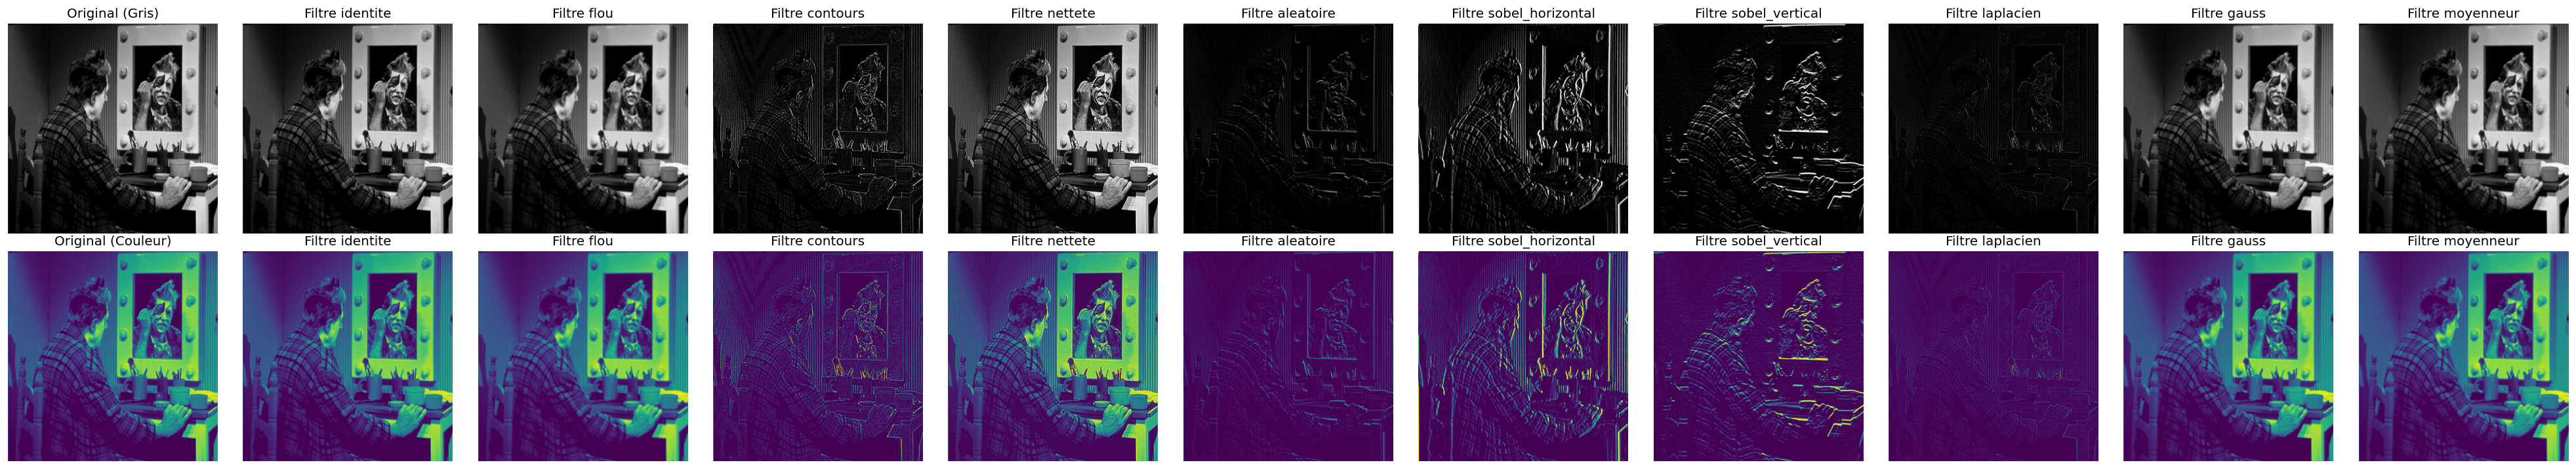

In [31]:
# Affichage de l'image originale + des images filtrées pour chaque filtre (gris et couleur)
nb_filtres = len(filtres)
fig, axes = plt.subplots(nrows=2, ncols=nb_filtres+1, figsize=(3*(nb_filtres+1), 6))

# Première colonne : images originales
axes[0, 0].imshow(image_gris, cmap='gray')
axes[0, 0].set_title("Original (Gris)")
axes[0, 0].axis('off')

axes[1, 0].imshow(image_couleur.astype(np.uint8))
axes[1, 0].set_title("Original (Couleur)")
axes[1, 0].axis('off')

# Colonnes suivantes : images filtrées
col = 1
for nom, noyau in filtres.items():
    # Image niveaux de gris filtrée
    axes[0, col].imshow(resultats_gris[nom], cmap='gray')
    axes[0, col].set_title(f"Filtre {nom}")
    axes[0, col].axis('off')
    # Image couleur filtrée
    axes[1, col].imshow(resultats_couleur[nom])
    axes[1, col].set_title(f"Filtre {nom}")
    axes[1, col].axis('off')
    col += 1

plt.tight_layout()
plt.show()


In [32]:
import time
import pandas as pd
import matplotlib.pyplot as plt

def apply_convolution(img, filters):
    """Applique la convolution 2D d'un noyau sur une image."""
    return appliquer_filtre(img, filters)

def measure_time(img, filter, n_iter=5):
    """Retourne le temps moyen d’exécution (en secondes) de apply_convolution."""
    t0 = time.perf_counter()
    for _ in range(n_iter):
        _ = apply_convolution(img, filter)
    return (time.perf_counter() - t0) / n_iter


In [33]:
results = []
for name, kern in filtres.items():
    t_gray = measure_time(image_gris, kern, n_iter=5)
    t_rgb  = measure_time(image_couleur, kern, n_iter=5)
    results.append({'filter': name, 'time_gray': t_gray, 'time_rgb': t_rgb})

df_perf = pd.DataFrame(results)
df_perf


filter  time_gray  time_rgb
0          identite   0.021076  0.013305
1              flou   0.013547  0.014014
2          contours   0.014655  0.012701
3           nettete   0.011260  0.011931
4         aleatoire   0.013839  0.011018
5  sobel_horizontal   0.011015  0.011118
6    sobel_vertical   0.011311  0.012970
7         laplacien   0.011465  0.011026
8             gauss   0.011407  0.036048
9         moyenneur   0.014676  0.014445

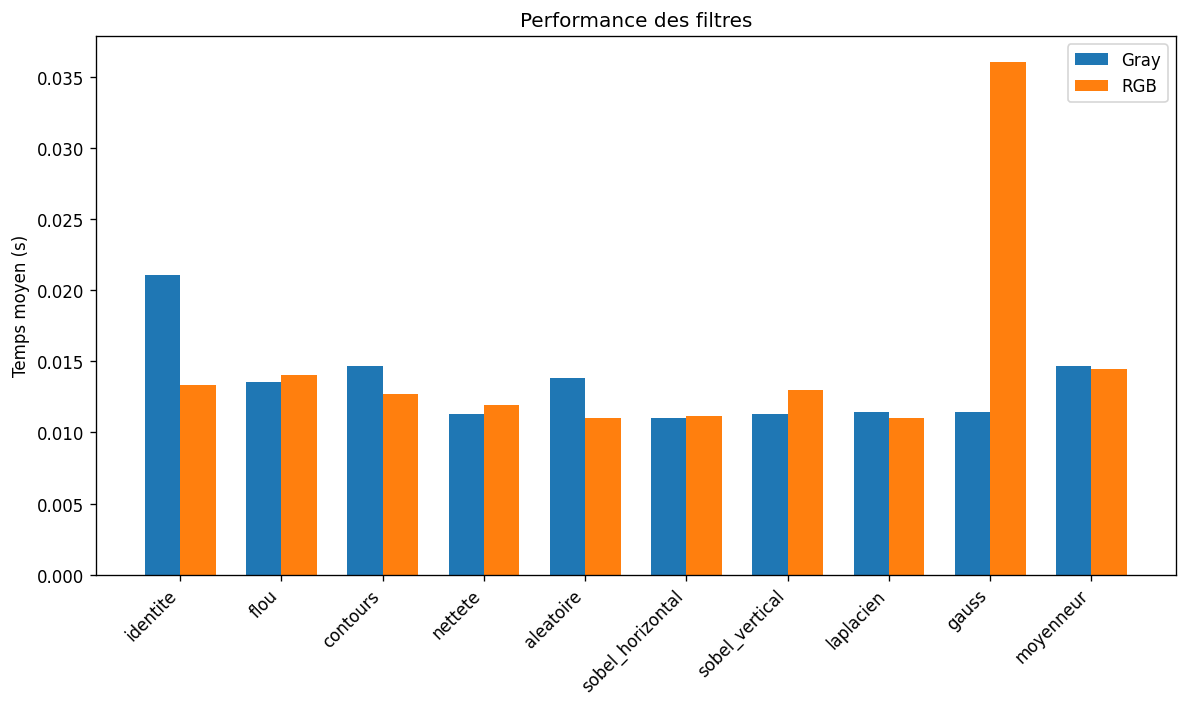

In [34]:
plt.figure(figsize=(10,6))
x = range(len(df_perf))
w = 0.35

plt.bar([i-w/2 for i in x], df_perf['time_gray'], width=w, label='Gray')
plt.bar([i+w/2 for i in x], df_perf['time_rgb'],  width=w, label='RGB')

plt.xticks(x, df_perf['filter'], rotation=45, ha='right')
plt.ylabel('Temps moyen (s)')
plt.title('Performance des filtres')
plt.legend()
plt.tight_layout()
plt.show()


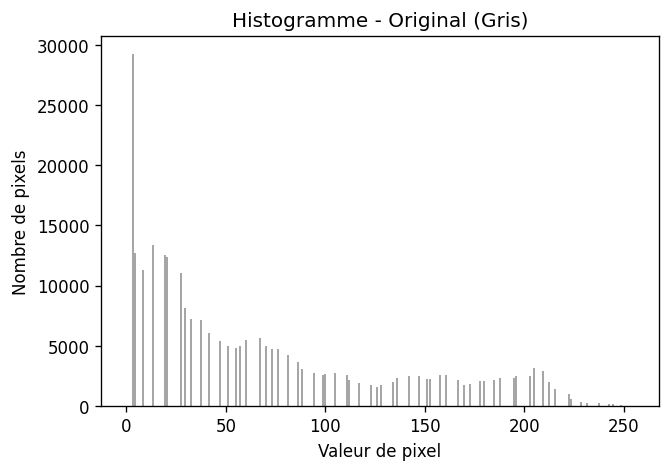

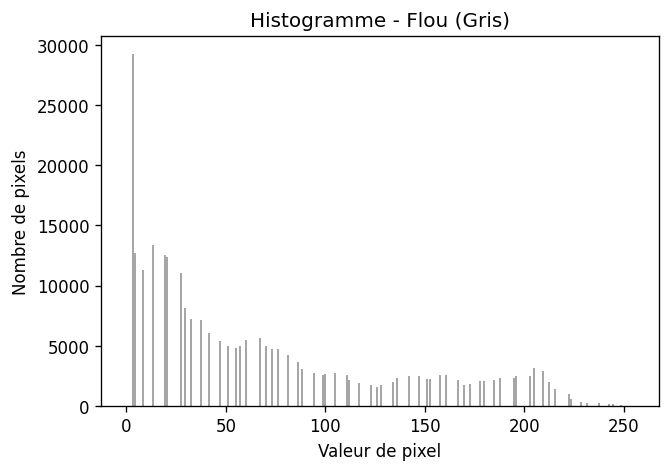

In [35]:

def plot_histogram(image, title):
    """Affiche l'histogramme des intensités de pixels pour une image en niveaux de gris."""
    plt.figure(figsize=(6,4))
    plt.hist(image.ravel(), bins=256, range=(0,255), color='gray', alpha=0.7)
    plt.title(f"Histogramme - {title}")
    plt.xlabel("Valeur de pixel")
    plt.ylabel("Nombre de pixels")
    plt.show()

# Histogramme avant/après filtre de flou
plot_histogram(image_gris, "Original (Gris)")
plot_histogram(image_couleur, "Flou (Gris)")


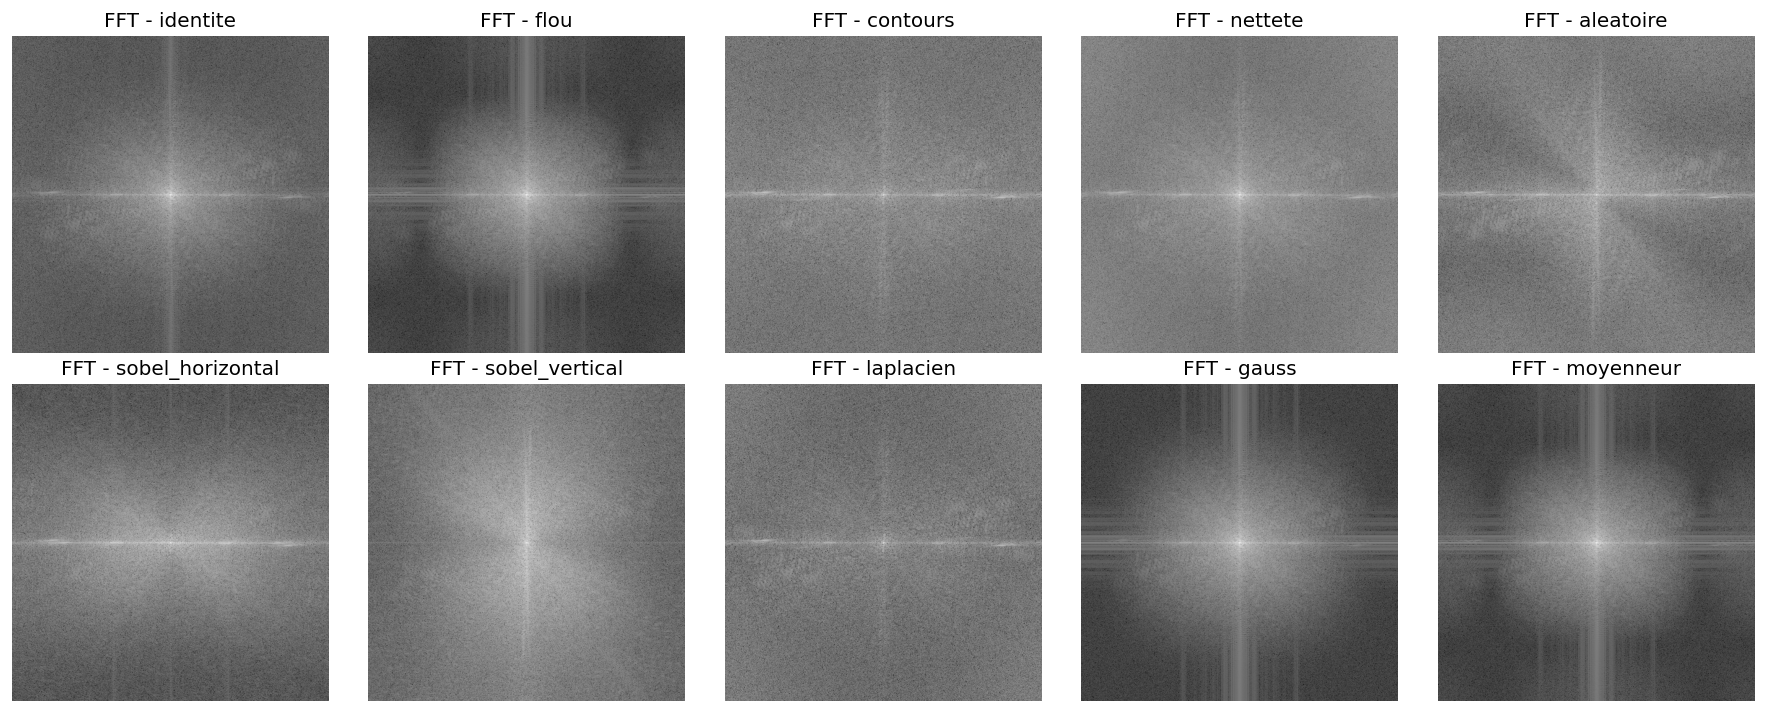

In [36]:

def compute_fft(image):
    """Calcule la FFT d'une image en niveaux de gris et applique un shift pour centrer les basses fréquences."""
    fft = np.fft.fft2(image)
    fft_shift = np.fft.fftshift(fft)  # Met le zéro fréquence au centre
    magnitude_spectrum = np.log(np.abs(fft_shift) + 1)  # Échelle logarithmique
    return magnitude_spectrum

def plot_fft_grid(images, titles, rows=2, cols=5):
    """Affiche les FFT des images en grille (rows x cols)."""
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 3, rows * 3))
    
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            spectrum = compute_fft(images[i])
            ax.imshow(spectrum, cmap='gray')
            ax.set_title(titles[i])
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Liste des images filtrées et leurs noms
filtered_images = [resultats_gris[nom] for nom in filtres.keys()]  # Images filtrées (gris)
filtered_titles = [f"FFT - {nom}" for nom in filtres.keys()]  # Noms des filtres

# Affichage des FFT en 2 lignes et 5 colonnes
plot_fft_grid(filtered_images, filtered_titles, rows=2, cols=5)


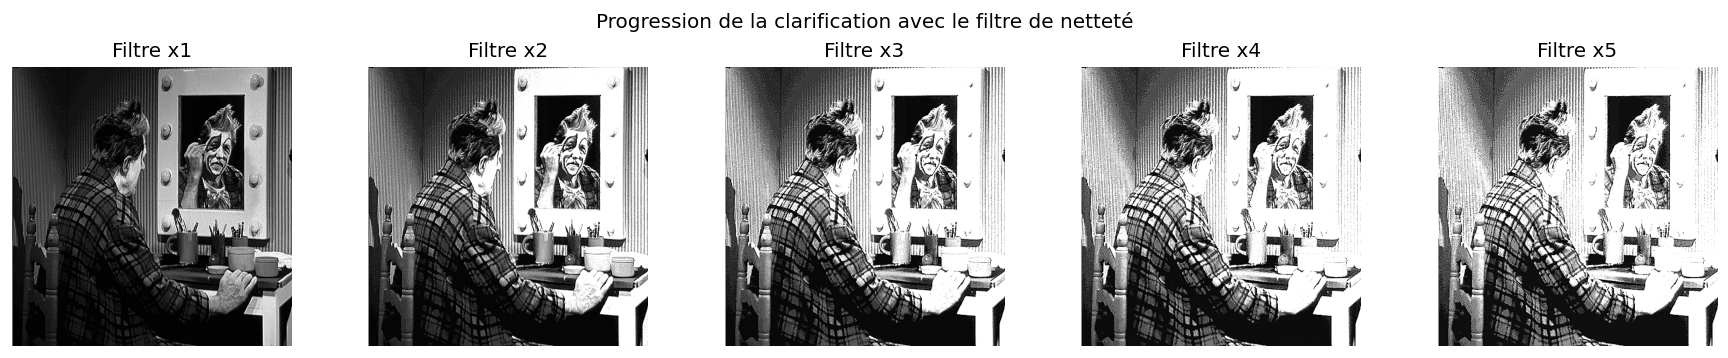

In [37]:
import cv2
import os

# Chargement de l'image
image_path = "clown.bmp"  # Image fournie par l'utilisateur
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Vérifier si l'image est bien chargée
assert image is not None, "Erreur : Impossible de charger l’image."

# Définition du filtre de netteté (Sharpening)
kernel_sharpen = np.array([
    [ 0, -1,  0],
    [-1,  5, -1],
    [ 0, -1,  0]
])

# Créer un dossier pour sauvegarder les images
output_folder = "filtered_images"
os.makedirs(output_folder, exist_ok=True)

# Appliquer le filtre avec différentes intensités et sauvegarder chaque étape
fig, axes = plt.subplots(1, 5, figsize=(15, 3))  # 5 étapes de filtrage
levels = [1, 2, 3, 4, 5]  # Intensité du filtre

for i, level in enumerate(levels):
    enhanced_kernel = kernel_sharpen * level  # Intensification du filtre
    filtered_image = cv2.filter2D(image, -1, enhanced_kernel)  # Convolution
    
    # Sauvegarde de l'image
    filename = f"{output_folder}/filtered_{level}.jpg"
    cv2.imwrite(filename, filtered_image)
    
    # Affichage
    axes[i].imshow(filtered_image, cmap='gray')
    axes[i].set_title(f"Filtre x{level}")
    axes[i].axis('off')

plt.suptitle("Progression de la clarification avec le filtre de netteté")
plt.tight_layout()
plt.show()


In [38]:
import os

# Chemin du dossier où sauvegarder les images
dossier_sortie = r"C:\Users\A\Desktop\images_vs"

# Créer le dossier s'il n'existe pas
os.makedirs(dossier_sortie, exist_ok=True)

# Sauvegarde des résultats de filtrage dans des fichiers image
for nom, img in resultats_gris.items():
    chemin_complet = os.path.join(dossier_sortie, f"resultat_{nom}_gris.png")
    Image.fromarray(img).save(chemin_complet)
    
for nom, img in resultats_couleur.items():
    chemin_complet = os.path.join(dossier_sortie, f"resultat_{nom}_couleur.png")
    Image.fromarray(img).save(chemin_complet)
print(f"Les images filtrées ont été sauvegardées avec succès dans le dossier : {dossier_sortie}")

PermissionError: [WinError 5] Accès refusé: 'C:\\Users\\A'